## Two time transformation application on HMM

### Import data and model training

In [39]:
!pip install hmmlearn
!pip install /root/msspackages/dist/msspackages-0.0.5-py3-none-any.whl
from msspackages import setup_runner
setup_runner(setup_type = 'notebook' , project = 'understanding-eks-data')

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'
Processing /root/msspackages/dist/msspackages-0.0.5-py3-none-any.whl
msspackages is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
b"Hit:1 http://security.debian.org/debian-security buster/updates InRelease\nHit:2 http://deb.debian.org/debian buster InRelease\nHit:3 http://deb.debian.org/debian buster-updates InRelease\nReading package lists...\nBuilding dependency tree...\nReading state information...\n59 packages can be upgraded. Run 'apt list --upgradable' to see them.\nReading package lists...\nBuilding dependency tree...\nReading state information...\nsudo is already the newest version (1.8.27-1+deb10u4).\n0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.\nReading package lists...\nBuilding dependency tree...\nReading state information...\ndefault-jre is already the newest ve

Keyring is skipped due to an exception: 'keyring.backends'
Processing /root/msspackages/dist/msspackages-0.0.5-py3-none-any.whl
  Using cached pyspark-3.3.1-py2.py3-none-any.whl
  Using cached configparser-5.3.0-py3-none-any.whl (19 kB)
  Using cached py4j-0.10.9.5-py2.py3-none-any.whl (199 kB)


b"Get:1 http://deb.debian.org/debian buster InRelease [122 kB]\nGet:2 http://security.debian.org/debian-security buster/updates InRelease [34.8 kB]\nGet:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]\nGet:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [408 kB]\nGet:5 http://deb.debian.org/debian buster/main amd64 Packages [7909 kB]\nGet:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [8788 B]\nFetched 8539 kB in 1s (6537 kB/s)\nReading package lists...\nBuilding dependency tree...\nReading state information...\n62 packages can be upgraded. Run 'apt list --upgradable' to see them.\nReading package lists...\nBuilding dependency tree...\nReading state information...\nThe following NEW packages will be installed:\n  sudo\n0 upgraded, 1 newly installed, 0 to remove and 62 not upgraded.\nNeed to get 1244 kB of archives.\nAfter this operation, 3883 kB of additional disk space will be used.\nGet:1 http://security.debian.org/

In [40]:
from msspackages import Pyspark_data_ingestion
from pyspark import StorageLevel
from pyspark.sql.functions import *
from hmmlearn import hmm,base

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
# pandas settings 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [41]:
%%time
node_obj = Pyspark_data_ingestion(year = '2022', month = "7", day = "7", hour = "10", filter_column_value ='Node',setup='128gb')
spark_node = node_obj.get_spark()
err, node_data = node_obj.read()

CPU times: user 17.5 ms, sys: 7.66 ms, total: 25.2 ms
Wall time: 386 ms


In [42]:
df = node_data.toPandas()

## Transform data

 let's start with univariate data..

In [90]:
### define the function for transform data base on independent node
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#df = df[['node_cpu_utilization','node_memory_utilization','Timestamp','NodeName']]
df = df[['node_cpu_utilization','Timestamp','NodeName']]
value_dict = {}
nodes = df.NodeName.unique()
for node in nodes:
    #data = df[df.NodeName==node]\
    #                             [['node_cpu_utilization','node_memory_utilization']].values
    data = df[df.NodeName==node]\
                                 ['node_cpu_utilization'].values
    data = data.reshape(-1,1)
    scaler.fit(data)
    value_dict[node] = scaler.transform(data)

In [91]:
### slice the data based on timestamp, I will use 6 for now as David suggested
#slice_length = 6
def find_num_slice(data,slice_length=6):
    num_slice = int(len(data)/slice_length)
    return num_slice
def transform_data(data):
    num_slice = find_num_slice(data)
    data = data[:num_slice*6]
    #data.shape = (6,num_slice,2)
    data.shape = (6,num_slice)
    return data

In [92]:
for key in value_dict.keys():
    value_dict[key] = transform_data(value_dict[key])

## train model with data from one node

In [93]:
train = value_dict['ip-100-64-19-132.us-west-2.compute.internal']

In [102]:
from hmmlearn import hmm
model = hmm.GaussianHMM(n_components = 2\
                        ,n_iter = 1000, random_state = 42)
model.fit(train)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, implementation='log', init_params='stmc',
            means_prior=0, means_weight=0, min_covar=0.001, n_components=2,
            n_iter=1000, params='stmc', random_state=42, startprob_prior=1.0,
            tol=0.01, transmat_prior=1.0, verbose=False)

In [111]:
model.predict(train)

array([0, 0, 1, 0, 0, 1])

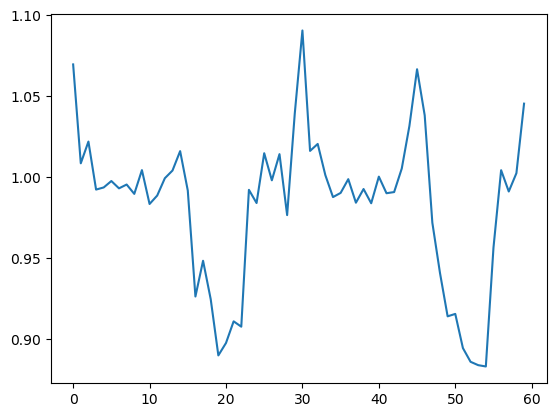

In [121]:
import matplotlib.pyplot as plt
plt.plot(df[df.NodeName=='ip-100-64-19-132.us-west-2.compute.internal'].node_cpu_utilization.reset_index(drop=True))

# the model currently have two problems
1. it cannot be applied on models with large number of states for small training sets
2. univariate only (not including timestamp)

In [125]:
nodelist =df.NodeName.unique()
model.predict(value_dict[nodelist[2]])

array([0, 0, 0, 0, 0, 0])

In [ ]:
model.fit